<h1 align="center">Map Stage</h1>

# Goal

Predict the total map duration based on the map task durations, amount of workers and input data size.

# Strong-Scaling Experiment

Find below some information about the experiment whose logs are analysed in this work.

In [1]:
# Notebook configuration and modules import

# Show graph in this notebook instead of opening a window
%matplotlib inline

# Make graphs more readable
import matplotlib
matplotlib.rcParams.update({'font.size': 16,
                            'font.family': 'serif',
                            'lines.linewidth': 2})

from lib import Experiment, HDFS, Spark, Plotter, R2
from common import *

In [2]:
ss_xp = Experiment()  # Strong-scaling experiment
ss_xp.parse('strong_scaling_data/app-*')

In [3]:
# Some experiment information

hdfs = HDFS(data_size=48542876756, block_size=128 * 1024 * 1024)

# Number of tasks in each application (first stage)
ns_tasks = set([len(app.stages[0].tasks) for app in ss_xp.get_apps()])
assert len(ns_tasks) == 1  # All executions have the same number of tasks
n_tasks = ns_tasks.pop()
assert n_tasks == hdfs.n_blocks  # 1 task per hdfs block

info = '* Input size: {:.1f} GB\n'.format(hdfs.data_size/1024**3)
info += '* Input blocks (128 MB each) == map tasks: {:d}\n'.format(hdfs.n_blocks)
info += '* Worker amounts: {}\n'.format(', '.join((str(w) for w in ss_xp.n_nodes)))
info += '* Executions: {:d} (30 for each worker amount, 1 outlier removed)\n'.format(ss_xp.n_apps)
info += '* Total map tasks: {:d} x {:d} = {:d}'.format(ss_xp.n_apps, n_tasks, ss_xp.n_apps * n_tasks)
Markdown(info)

* Input size: 45.2 GB
* Input blocks (128 MB each) == map tasks: 362
* Worker amounts: 4, 8, 16, 32, 64
* Executions: 150 (30 for each worker amount, 1 outlier removed)
* Total map tasks: 150 x 362 = 54300

## Map stage durations
The figure below shows the map durations from all the executions. The line that connects their means will be used in other figures to compare with the model results.

In [4]:
ss_xp.reject_stage_outliers(0, 5)

INFO: Removed outlier (8, 228290).


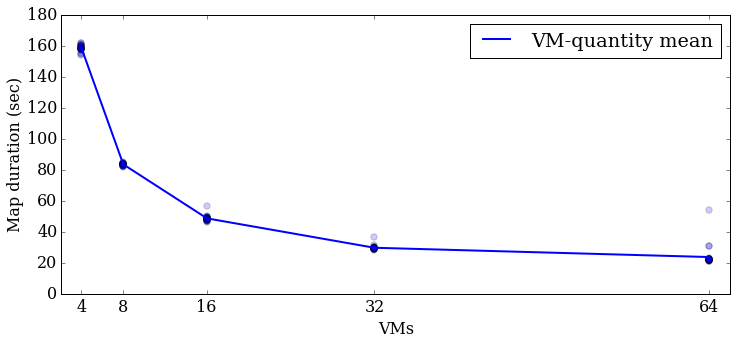

All map stage durations and their means per worker amount.

In [299]:
def plot_means(pltr, xp, *args, **kwargs):
    pltr.set_ys_fn(lambda ys: ys/1000)  # from ms to sec
    pltr.plot_means(xp.n_nodes, xp.get_stage_lists(0), *args, label='VM-quantity mean', **kwargs)
    pltr.set_labels('VMs', 'Map duration (sec)')
    plt.xticks(xp.n_nodes)
    plt.ylim(0, 180)
    plt.xlim(xp.n_nodes[0] - 2, xp.n_nodes[-1] + 2)
    
pltr = Plotter()
plot_means(pltr, ss_xp)
scatter_xs = [a.workers for a in ss_xp.get_apps()]
pltr.scatter(scatter_xs, ss_xp.get_stage(0), alpha=0.2, s=40)
plt.legend()
plt.show()

Markdown('All map stage durations and their means per worker amount.')

# Mean model

This model uses the task time durations to predict the whole map durations. In this first approach, we first calculate the mean duration of all tasks (~54k tasks). Then, we multiply it by the number of tasks each worker will execute.

The tasks are distributed evenly across all the nodes and, if some worker executes more tasks than other, we consider the highest amount of tasks. In this experiment, each worker has 2 threads. The total map duration is calculate by the function below.

In [6]:
# total time = (highest) number of tasks per worker x task time mean
def mean_model(workers, tasks, task_time):
    return np.ceil(tasks/workers) * task_time

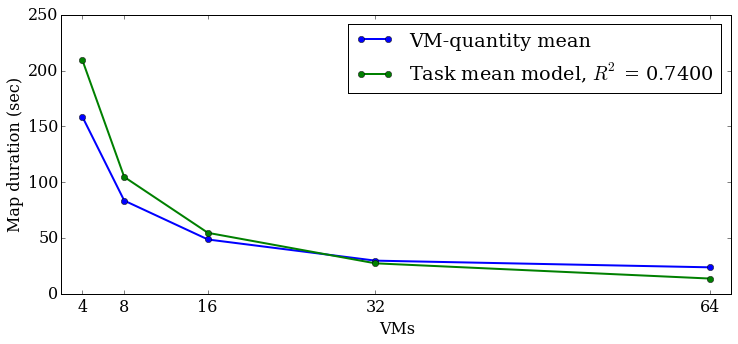

Comparison between the average of map durations and the model based on the mean of all tasks.

In [7]:
task_mean_time = np.mean([t.duration for s in ss_xp.get_stage(0)
                                     for t in s.tasks])
def model(nodes): return mean_model(2 * nodes, n_tasks, task_mean_time)

# Plot means
pltr = Plotter()
plot_means(pltr, ss_xp, '-o')

# R2 calculation
xs = (a.workers for a in ss_xp.get_apps())
ys = (s.duration for s in ss_xp.get_stage(0))
r2c = R2(xs, ys)
r2 = r2c.calc_from_fn(model)
label = r2c.get_label('Task mean model', r2)

# Plot model
ys = [model(nn)/1000 for nn in ss_xp.n_nodes]
plt.plot(ss_xp.n_nodes, ys, '-o', label=label)

plt.ylim(ymax=250)
plt.legend()
plt.show()

Markdown('Comparison between the average of map durations and the model based on the mean of all tasks.')

As we can notice, the prediction error is bigger as the amount of worker goes below 16 or beyond 32.

# Task duration distribution
To improve the model, we should understand the distribution of the map stage tasks.

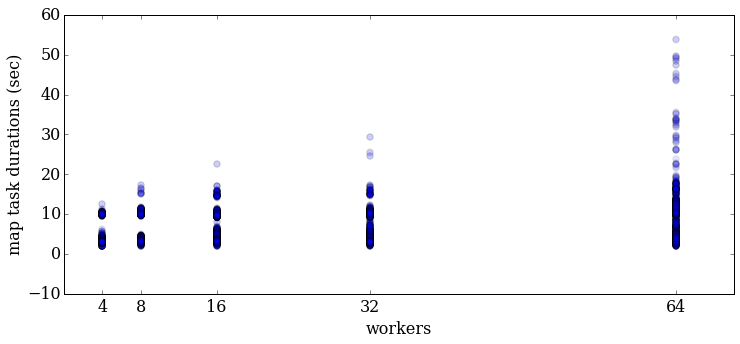

Duration of all tasks from all executions grouped by worker amount.

In [7]:
# Tasks' durations
plt.subplots(figsize=(12,5))

for app in apps:
    _ys = [t.duration/1000 for t in app.stages[0].tasks]
    _xs = [app.workers] * len(_ys)
    plt.scatter(_xs, _ys, alpha=0.1, s=40)

plt.xticks(worker_amounts)
plt.xlabel('workers')
plt.ylabel('map task durations (sec)')
plt.show()

Markdown('Duration of all tasks from all executions grouped by worker amount.')

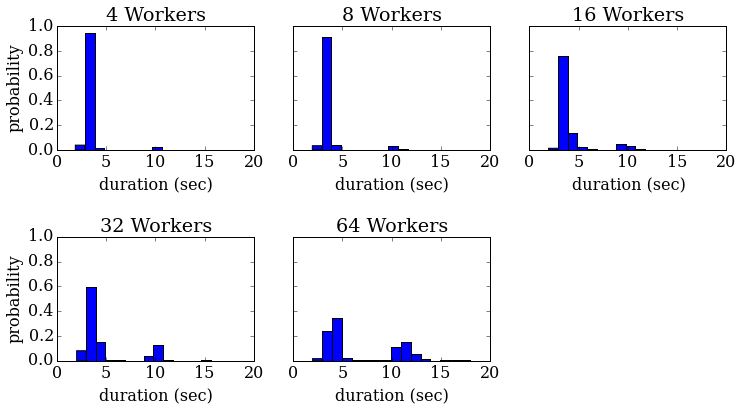

Histograms of task durations.

In [8]:
# Plot task duration histogram per worker amount

fig, axs = plt.subplots(2, 3, figsize=(12,6), sharey=True)
axs[-1, -1].axis('off')
fig.subplots_adjust(hspace=0.7)

for n, workers in enumerate(worker_amounts):
    ax = axs[int(n/3)][n%3]
    _apps = (a for a in apps if a.workers == workers)
    durations = np.array([t.duration/1000 for a in _apps for t in a.stages[0].tasks])
    bins = max(durations) - min(durations) + 1
    ax.hist(durations, bins, normed=True)
    ax.set_xlabel('duration (sec)')
    ax.set_xlim(0, 20)
    ax.set_ylim(0, 1)
    ax.set_title('{:d} Workers'.format(workers))
    if n == 0 or n == 3:
        ax.set_ylabel('probability')
    #if workers == 64:
    #    ax.set_yticks(np.arange(0, 0.41, 0.1))
plt.show()

Markdown('Histograms of task durations.')

In the histograms above, a second curve around 10 seconds becomes more evident as the number of workers increases. In the next section, we investigate the longer tasks

## Longer tasks

We now analyse only the tasks that take longer than 8 seconds to finish.

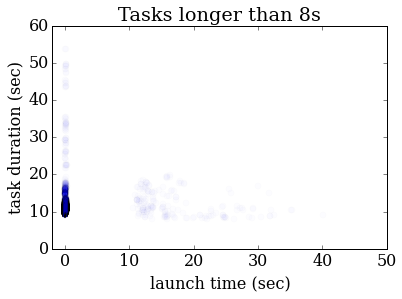

Longer tasks and their launch time since the first map task start.

In [9]:
# Scatterplot

for app in apps:
    map_tasks = [t for t in app.stages[0].tasks if t.duration >= 8000]
    _ys = [task.duration/1000 for task in map_tasks]
    _xs = np.array([task.start for task in map_tasks])
    _xs = (_xs - min(_xs))/1000
    plt.scatter(_xs, _ys, alpha=0.01, s=40)
plt.xlim(xmin=-2)
plt.ylabel('task duration (sec)')
plt.xlabel('launch time (sec)')
plt.title('Tasks longer than 8s')
plt.show()

Markdown('Longer tasks and their launch time since the first map task start.')

The figure above reveals that the longer tasks are highly concentrated in the very beginning of the map phase.
The cumulative distribution function below can give us more information.

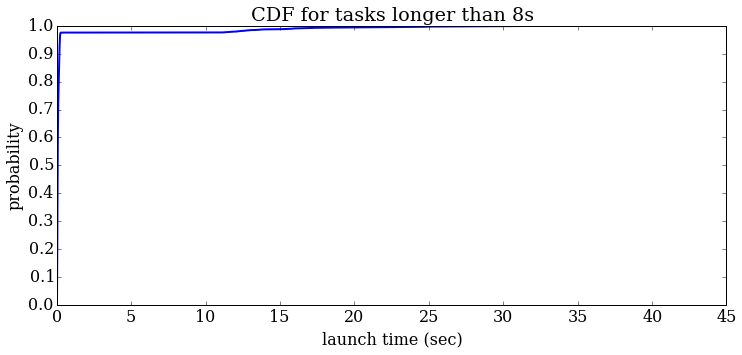

Cumulative distribution function of the tasks longer than 8 seconds.

In [10]:
# Long tasks' CDF

plt.subplots(figsize=(12,5))

starts = []
for app in apps:
    _starts = np.array([t.start for t in app.stages[0].tasks if t.duration >= 8000])
    starts.extend((_starts - min(_starts))/1000)
starts.sort()    

_xs = [starts[0]]
_ys = [1]
for start in starts[1:]:
    if start == _xs[-1]:
        _ys[-1] += 1
    else:
        _xs.append(start)
        _ys.append(1)

_ys = np.array(_ys)
_ys = _ys/_ys.sum()

plt.plot(_xs, _ys.cumsum(), linewidth=2)
plt.title('CDF for tasks longer than 8s')
plt.xlabel('launch time (sec)')
plt.ylabel('probability')
plt.yticks(np.linspace(0, 1, 11))
plt.ylim(ymax=1)
plt.show()

Markdown('Cumulative distribution function of the tasks longer than 8 seconds.')

We can notice in the CDF that more than 95% of the slowest tasks start up to 1 second after the first map.

In [11]:
# Fastest task duration, in seconds
min((t.duration for app in apps for t in app.stages[0].tasks))/1000

1.878

As the fastest task has more than one second (as calculated above), we conclude that the vast majority of the longer tasks are the first ones to be scheduled. With that in mind, we propose another model discussed below.

# Two-mean model

Based on the distribution of the task durations, we evaluate a model with based on two means: one for the first tasks to be executed in each thread and another for all the other tasks. The total map duration time includes the higher mean value to process the first tasks in parallel. More time is added using the remaining tasks and the lower mean as in the previous model.

In [8]:
def two_mean_model(workers, tasks, high_mean, low_mean):
    """
      workers: amount of workers
        tasks: number of tasks
    high_mean: mean duration of the first tasks
     low_mean: mean duration of the remaining tasks
    """
    total_time = high_mean  # all the workers process their first task
    total_time += mean_model(workers, tasks - workers, low_mean)
    return total_time

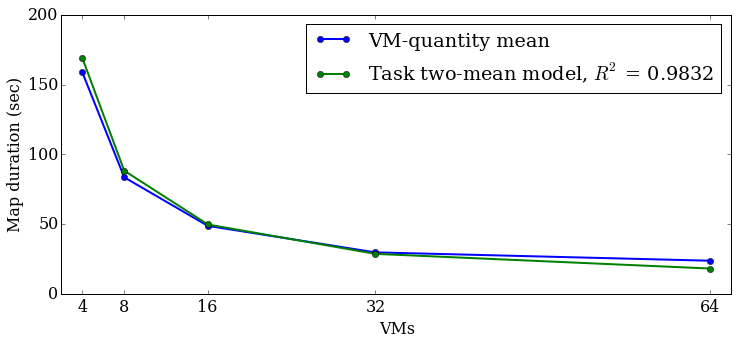

Comparison between the average of map durations and the model based on the mean of all tasks.

In [11]:
high_mean = np.mean([t.duration for a in ss_xp.get_apps()
                                for t in a.stages[0].tasks[:a.workers*2]])
low_mean = np.mean([t.duration for a in ss_xp.get_apps()
                               for t in a.stages[0].tasks[a.workers*2:]])

def model(nodes): return two_mean_model(nodes*2, n_tasks, high_mean, low_mean)

# Plot means
pltr = Plotter()
plot_means(pltr, ss_xp, '-o')

# R2 calculation
xs = (a.workers for a in ss_xp.get_apps())
ys = (s.duration for s in ss_xp.get_stage(0))
r2c = R2(xs, ys)
r2 = r2c.calc_from_fn(model)
label = r2c.get_label('Task two-mean model', r2)

# Plot model
ys = [model(nn)/1000 for nn in ss_xp.n_nodes]
plt.plot(ss_xp.n_nodes, ys, '-o', label=label)

plt.ylim(ymax=200)
plt.legend()
plt.show()

Markdown('Comparison between the average of map durations and the model based on the mean of all tasks.')

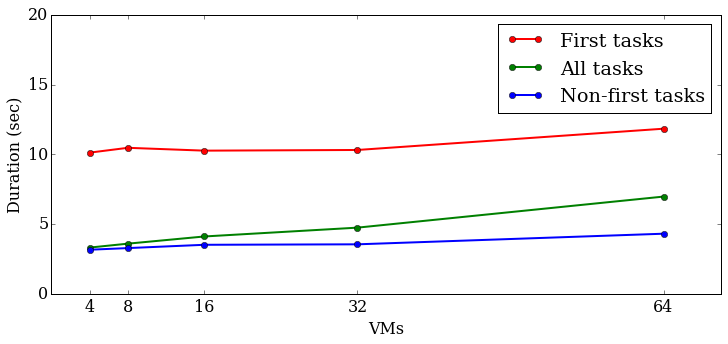

In [320]:
def plot_tasks(xp):
    pltr = Plotter()
    pltr.set_ys_fn(lambda ys: ys/1000)
    pltr.plot_means(xp.n_nodes, xp.get_first_tasks(0), '-o', label='First tasks', c='r')
    pltr.plot_means(xp.n_nodes, xp.get_tasks(0), '-o', label='All tasks')
    pltr.plot_means(xp.n_nodes, xp.get_nonfirst_tasks(0), '-o', label='Non-first tasks', c='b')
    pltr.set_labels('VMs', 'Duration (sec)')
    plt.ylim(ymin=0)
    plt.xticks(xp.n_nodes)
    plt.legend(loc=0)
    
plot_tasks(ss_xp)
plt.ylim(0, 20)
plt.show()

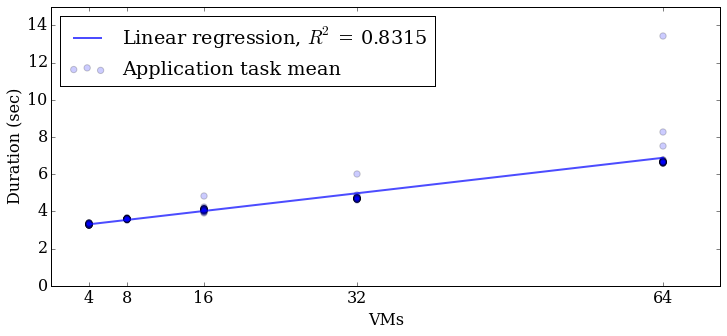

In [309]:
# TODO r2 em relação a todas as tasks, e não à média
import itertools

def plot_task_mean_reg(plotter, xp):
    pltr.set_ys_fn(lambda ys: ys/1000)
    pltr.set_labels('VMs', 'Duration (sec)')

    # Scatterplot
    task_means = [np.mean([t.duration for t in a.stages[0].tasks]) for a in xp.get_apps()]
    xs = [a.workers for a in xp.get_apps()]
    plt.scatter(xs, np.array(task_means)/1000, s=40, alpha=0.2, label='Application task mean')

    # Linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(xs, task_means)
    def linreg(nodes): return nodes * slope + intercept
    ys = [linreg(nn)/1000 for nn in xp.n_nodes]
    label = R2.get_label('Linear regression', r_value**2)
    plt.plot(xp.n_nodes, ys, 'b-', label=label, alpha=0.7)

    plt.ylim(ymin=0)
    plt.xticks(xp.n_nodes)
    plt.legend(loc=0)
    
    return slope, intercept

ss_slope, ss_intercept = plot_task_mean_reg(Plotter(), ss_xp)
plt.ylim(0, 15)
plt.legend(loc='upper left')
plt.show()

In [218]:
# Linear-mean model
def linear_mean_model(slope, intercept, nodes, tasks):
    threads = 2
    task_mean = slope * nodes + intercept
    return mean_model(threads * nodes, tasks, task_mean)

In [162]:
def model(nodes): return linear_mean_model(slope, intercept, nodes, n_tasks)

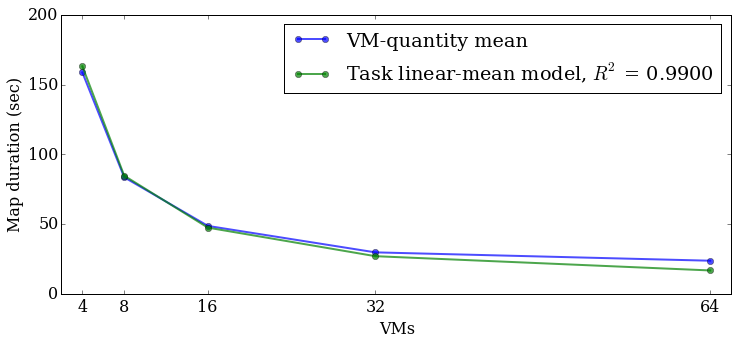

In [310]:
# Plot means
pltr = Plotter()
plot_means(pltr, ss_xp, '-o', alpha=0.7)

# R2 calculation
xs = (a.workers for a in ss_xp.get_apps())
ys = (s.duration for s in ss_xp.get_stage(0))
r2c = R2(xs, ys)
r2 = r2c.calc_from_fn(model)
label = R2.get_label('Task linear-mean model', r2)

# Plot model
ys = [model(nn)/1000 for nn in ss_xp.n_nodes]
plt.plot(ss_xp.n_nodes, ys, '-o', label=label, alpha=0.7)

plt.ylim(ymax=200)
plt.legend()
plt.show()

The two-mean model is much closer to the map duration mean than the previous model. With this better model, we use an execution with less resources to predict the strong-scaling experiment.

# Profiling phase

In the previous sections, we used the task durations from the strong-scaling experiment. However, in real life, we want to use as few resources (and money) as possible to predict the application scalability. In this section, we  use *only one worker and only one gigabyte of input data*.

* Input size: 1 GB
* Input blocks (128 MB each) == map tasks: 8
* Worker amounts: 1
* Executions: 30
* Total map tasks: 8 x 30 = 240

In [278]:
sss_xp = Experiment()
sss_xp.parse('small_strong_scaling_data/app-*')

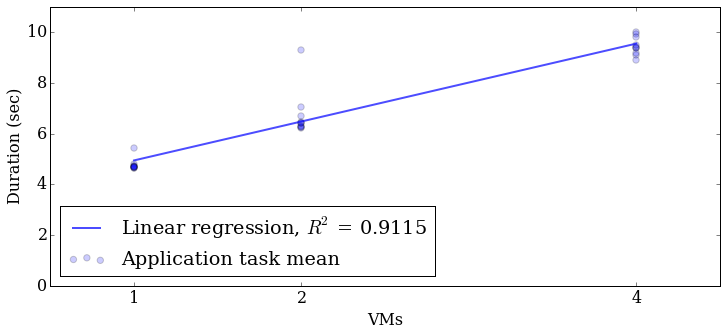

In [313]:
sss_slope, sss_intercept = plot_task_mean_reg(Plotter(), sss_xp)
plt.legend(loc='lower left')
plt.show()

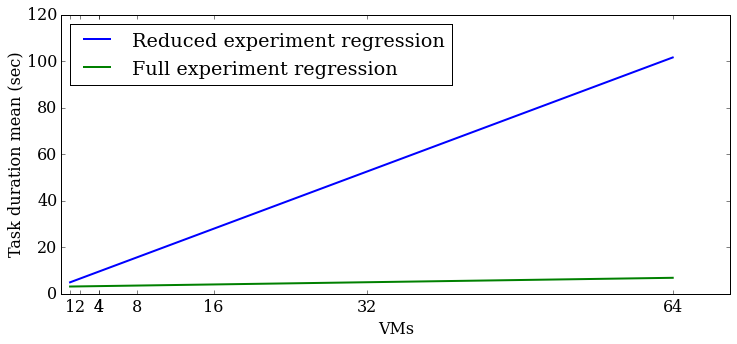

In [318]:
pltr = Plotter()
pltr.set_labels('VMs', 'Task duration mean (sec)')

def sss_linreg(nodes): return nodes * sss_slope + sss_intercept
def ss_linreg(nodes): return nodes * ss_slope + ss_intercept

xs = sss_xp.n_nodes + ss_xp.n_nodes
plt.plot(xs, [sss_linreg(x)/1000 for x in xs], label='Reduced experiment regression')
plt.plot(xs, [ss_linreg(x)/1000 for x in xs], label='Full experiment regression')

plt.xticks(xs)
plt.legend(loc='upper left')
plt.show()

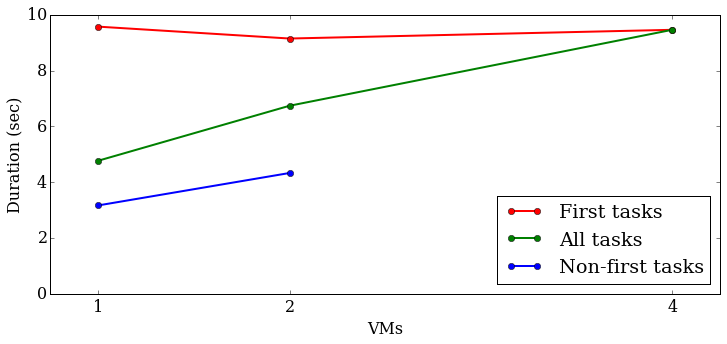

In [314]:
plot_tasks(sss_xp)
plt.xlim(0.75, 4.25)
plt.show()

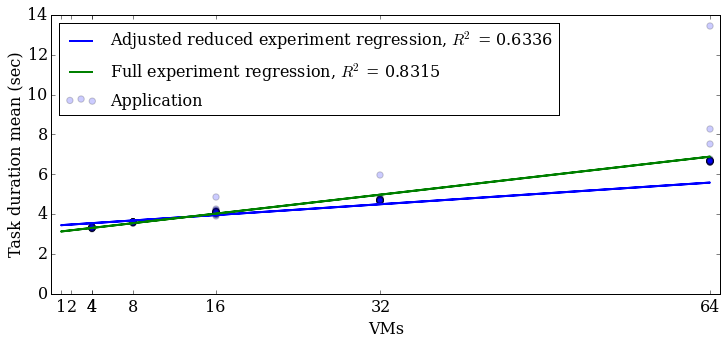

In [317]:
def calc_nodes(nodes, tasks, to_tasks):
    """
    From a reduced experiment, calculate the number of nodes in the full execution
    that will have the same duration.
    
    :param int nodes: number of nodes
    :param int tasks: number of tasks in the reduced experiment
    :param int to_tasks: number of tasks in the full execution
    """
    threads = 2
    workers = threads * nodes
    # non-first/first tasks
    ratio = (tasks - workers)/workers
    return to_tasks/(ratio + 1)/threads
    
pltr = Plotter()
pltr.set_labels('VMs', 'Task duration mean (sec)')
# Scatterplot
task_mean_ys = [np.mean([t.duration for t in a.stages[0].tasks]) for a in ss_xp.get_apps()]
task_mean_xs = [a.workers for a in ss_xp.get_apps()]
plt.scatter(task_mean_xs, np.array(task_mean_ys)/1000, s=40, alpha=0.2, label='Application')
r2c = R2(task_mean_xs, task_mean_ys)
    
# TODO change to mean instead of linear regression as the 3rd point will be discarded
# TODO sss_n_tasks
sss_n_tasks = 8
nodes = (1, 2)
ys = [sss_linreg(n) for n in nodes]
xs = [calc_nodes(n, sss_n_tasks, n_tasks) for n in nodes]
sss_adjusted_slope = (ys[1] - ys[0])/(xs[1] - xs[0])
sss_adjusted_intercept = ys[0] - sss_adjusted_slope * xs[0]
def sss_adjusted_linreg(nodes): return nodes * sss_adjusted_slope + sss_adjusted_intercept

xs = ss_xp.n_nodes + sss_xp.n_nodes
r2 = r2c.calc_from_fn(sss_adjusted_linreg)
label = R2.get_label('Adjusted reduced experiment regression', r2)
plt.plot(xs, [sss_adjusted_linreg(x)/1000 for x in xs], label=label, c='b')

r2 = r2c.calc_from_fn(ss_linreg)
label = R2.get_label('Full experiment regression', r2)
plt.plot(xs, [ss_linreg(x)/1000 for x in xs], label=label, c='g')
plt.xticks(xs)

plt.xlim(0, 65)
plt.ylim(ymin=0)
plt.legend(loc='upper left', fontsize=16)
plt.show()

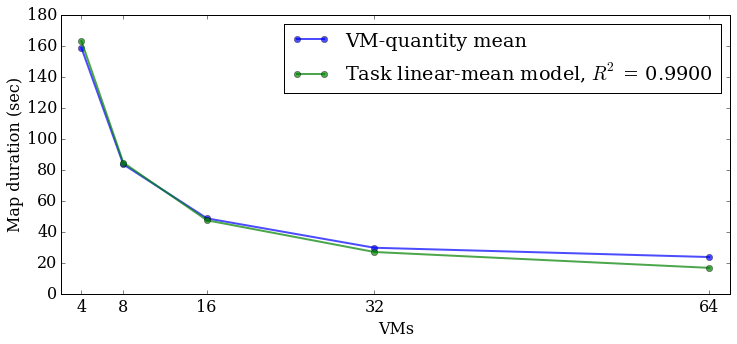

In [319]:
def model(nodes): return linear_mean_model(sss_adjusted_slope, sss_adjusted_intercept, nodes, n_tasks)

# Plot means
pltr = Plotter()
plot_means(pltr, ss_xp, '-o', alpha=0.7)

# R2 calculation
xs = (a.workers for a in ss_xp.get_apps())
ys = (s.duration for s in ss_xp.get_stage(0))
r2c = R2(xs, ys)
r2 = r2c.calc_from_fn(model)
label = R2.get_label('Task linear-mean model', r2)

# Plot model
ys = [model(nn)/1000 for nn in ss_xp.n_nodes]
plt.plot(ss_xp.n_nodes, ys, '-o', label=label, alpha=0.7)

plt.ylim(ymax=180)
plt.legend()
plt.show()

### First tasks of full execution

0.978984136468


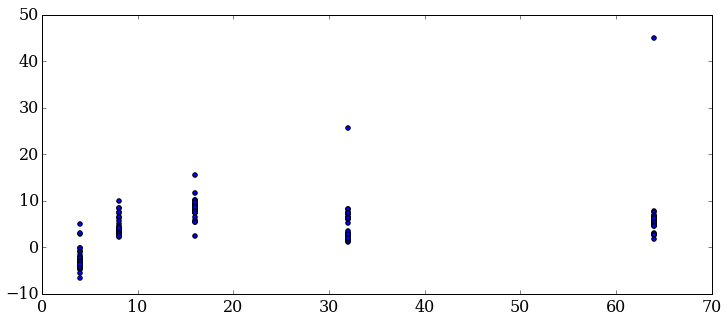

In [301]:
def predict_finish_time(app):
    threads = 2
    tasks = app.stages[0].tasks
    first_tasks_duration = max(t.duration for t in tasks[:app.workers])
    nonfirst_tasks_duration = np.mean([t.duration for t in tasks[app.workers:]])
    return two_mean_model(threads * app.workers, n_tasks, first_tasks_duration, nonfirst_tasks_duration)
    
apps = list(ss_xp.get_apps())
xs, ys, predictions = [], [], []
for previous, current in zip(apps[:-1], apps[1:]):
    if previous.workers != current.workers:
        continue
    xs.append(current.workers)
    ys.append(current.stages[0].duration)
    predictions.append(predict_finish_time(previous))
    
#for y, prediction in zip(ys, predictions):
#    print(y, prediction)
r2c = R2(xs, ys)
print(r2c.calc(predictions))

residuals = [prediction - y for prediction, y in zip(predictions, ys)]
pltr = Plotter()
plt.scatter(xs, np.array(residuals)/1000)
plt.show()

0.985188301906


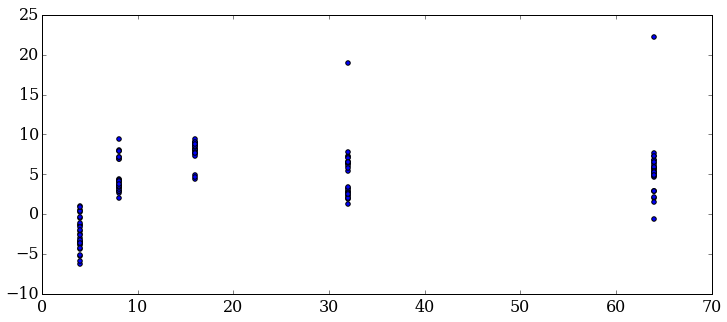

In [231]:
def predict_finish_time(app):
    threads = 2
    tasks = app.stages[0].tasks
    first_tasks_duration = max(t.duration for t in tasks[:app.workers])
    nonfirst_tasks_duration = np.mean([t.duration for t in tasks[app.workers:]])
    return two_mean_model(threads * app.workers, n_tasks, first_tasks_duration, nonfirst_tasks_duration)
    
apps = list(ss_xp.get_apps())
xs, ys, predictions = [], [], []
for app in ss_xp.get_apps():
    xs.append(app.workers)
    ys.append(app.stages[0].duration)
    predictions.append(predict_finish_time(app))
    
#for y, prediction in zip(ys, predictions):
#    print(y, prediction)
r2c = R2(xs, ys)
print(r2c.calc(predictions))

residuals = [prediction - y for prediction, y in zip(predictions, ys)]
pltr = Plotter()
plt.scatter(xs, np.array(residuals)/1000)
plt.show()

In [14]:
apps_weak1, _ = parse_weak_scaling(workers=[1])

NameError: name 'map_means' is not defined

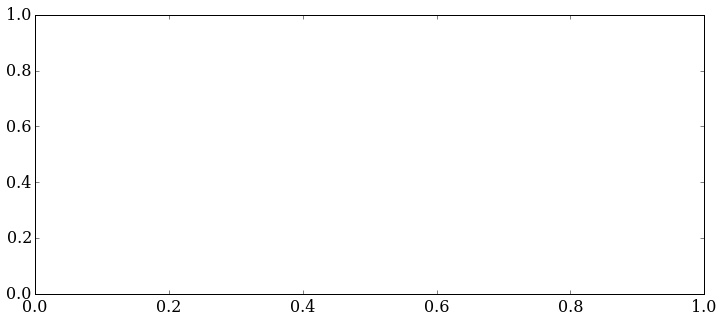

In [312]:
# Plot stage mean, two-mean model with strong-scaling and weak-scaling experiments

plt.subplots(figsize=(12,5))

plt.plot(ss_xp.n_nodes, map_means, 'b-o', label=map_label)
#plt.plot(worker_amounts, two_mean_model_ys, 'r-o', label=two_mean_model_label)

ys, r2, high, low = get_two_mean_durations(apps_weak1)
label = 'Task two-mean model (1 worker, 1 GB), ' + r'$R^{2}$' + ' = {:.4f}'.format(r2)
plt.plot(worker_amounts, ys, 'c-o', label=label)

plt.xlabel('workers')
plt.ylabel('map duration (sec)')
plt.xticks(worker_amounts)
plt.legend(fontsize=16)
plt.show()

Markdown('Two-mean model with reduced resource execution and parameters \
 n_tasks = {:d}, high_mean = {:.4f} ms, low_mean = {:.4f} ms.'.format(n_tasks, high*1000, low*1000))

# Conclusion

By running the application with 45 times less data in only one VM, it was possible to predict the map stage time within a satisfactory accuracy for the entire input data and several worker amounts.

# Next Steps
* Reduce stage prediction (a quick look revealed the same pattern)
* Other stages
* Total application time modeling

In [16]:
%%javascript // extension to hide code cells

//IPython.load_extensions('usability/codefolding/main');

<IPython.core.display.Javascript object>